In [64]:
import pandas as pd
import numpy as np
import re
import pymorphy2
import gensim
import os
import nltk
import json


from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
from pymystem3 import Mystem
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
import pymorphy2
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from json import JSONEncoder

pathBase = '/data/share/lab05data/'


In [65]:
# номера файлов для классификации
idTexts = [514, 3489, 9, 2570, 3084, 3086, 1040, 1113, 3603, 2582, 1559, 2591, 2081, 2602, 1281, 1289, 1076, 569, 2618, 572, 2622, 1599, 2100, 579, 581, 586, 1720, 78, 1616, 3665, 174, 85, 598, 599, 89, 1626, 2139, 3600, 2144, 1121, 1123, 2374, 2066, 3178, 1131, 2067, 624, 3433, 1139, 1658, 1659, 2173, 1151, 1664, 3719, 2696, 2185, 1932, 3214, 656, 1174, 3224, 665, 1691, 160, 161, 3041, 3239, 1704, 683, 1651, 1200, 2225, 2232, 695, 3256, 698,            1211, 1215, 1728, 3268, 2758, 3783, 715, 1230, 1232, 2258, 1806, 219, 1244, 1757, 808, 1262, 2799, 3824, 60, 1779, 1441, 1270, 1697, 257, 3332,       1798, 775, 2313, 1294, 273, 275, 2324, 3349, 3352, 1331, 1831, 3368, 3293, 307, 2864, 2353, 2579, 3892, 2869, 2362, 2876, 1343, 3904, 322, 836, 2885, 3398, 3913, 1355, 3405, 1360, 2386, 3925, 2902, 3415, 857, 347, 144, 2806, 3940, 999, 402, 2921, 1909, 1911, 377, 1406, 1407, 384, 2950, 903, 1928, 3468, 910, 1423, 3472, 2450, 406, 409, 2973, 2462, 1439, 2464, 2977, 2896, 1956, 1961, 1437, 427, 429, 1524, 950, 958, 758, 3233, 3524, 3013, 2504, 3530, 3020, 464, 2517, 3030, 3545, 336, 989, 3550, 479, 1951, 482, 2535, 2538, 1501, 3570, 2036, 887, 1016, 2200]

In [66]:
# список файлов файлов для классификации
testList = []
for i in idTexts:
    testList.append(pathBase + 'test_'+ str(i) + '.txt')

In [67]:
testDict = {}
for file in testList:
    with open (file, "r") as testfile:
        testDict[file] = testfile.read()
# датафрейм текстов для классификации
dfTest = (pd.DataFrame.from_dict(testDict, orient = 'index').reset_index().rename(index = str, columns = {'index': 'file_name', 0: 'text'})) 

In [68]:
baseFiles = []
for root, dirs, files in os.walk(pathBase):  
    for filename in files:
        if filename[:4] == 'base': 
           baseFiles.append(pathBase + filename)

In [69]:
textDict = {}
for file in baseFiles:
    with open (file, 'r') as bFile:
       textDict[file] = bFile.read()
# датафрейм текстов известной тематики
dfBase = (pd.DataFrame.from_dict(textDict, orient = 'index').reset_index().rename(index = str, columns = {'index': 'file_name', 0: 'text'}))    

In [70]:
print(len(dfBase))
print(len(dfTest))

20
200


In [71]:
dfText = dfBase.copy()
dfTst  = dfTest.copy()

In [72]:
dfText.iloc[0].text

'<p>В Группе компаний InfoWatch, которая объединяет ряд российских и зарубежных разработчиков программных продуктов и решений для обеспечения информационной безопасности организаций, противодействия внешним и внутренним угрозам, на конкурсной основе, открыта вакансия <strong>Старший программист C++ (лингвистические технологии).</strong></p> <p><strong>Обязанности:</strong></p> <ul> </ul> <ul> <li>разработка алгоритмов и их реализация на C++;</li> <li>составление технической документации по разрабатываемым компонентам;</li> <li>разработка unit-тестов;</li> <li>разработка, отладка, модификация и оптимизация отдельных сложных компонентов программной системы в соответствии с заданиями, выданными непосредственным руководителем;</li> <li>обзоры кода других разработчиков и рекомендации по его улучшению.</li> </ul> <p> </p> <p><strong>Требования:</strong></p> <ul> <li>знание <strong>С++ </strong>(опыт программирования от 3 лет);</li> <li>знания алгоритмов и структуры данных;</li> <li>высокая к

In [73]:
# функция очисткт тегов HTML, пустых сторок
def textBS(text):
   html = ''
   html = text
   soup = BeautifulSoup(html, features = 'html.parser')
   for script in soup(['script', 'style']):
       script.extract()    # rip it out  
   text = soup.get_text() 
   # break into lines and remove leading and trailing space on each
   lines = (line.strip() for line in text.splitlines())   
   # break multi-headlines into a line each
   chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
   # drop blank lines
   txt= '\n'.join(chunk for chunk in chunks if chunk)
   return txt.lower()


In [74]:
# очиска текстов известной тематики
for i in range(len(dfText)):
    dfText.iloc[i].text = textBS(dfText.iloc[i].text)

In [75]:
# очиска текстов неизвестной тематики
for i in range(len(dfTst)):
    dfTst.iloc[i].text = textBS(dfTst.iloc[i].text)

In [76]:
dfText.iloc[0].text

'в группе компаний infowatch, которая объединяет ряд российских и зарубежных разработчиков программных продуктов и решений для обеспечения информационной безопасности организаций, противодействия внешним и внутренним угрозам, на конкурсной основе, открыта вакансия старший программист c++ (лингвистические технологии). обязанности:\nразработка алгоритмов и их реализация на c++; составление технической документации по разрабатываемым компонентам; разработка unit-тестов; разработка, отладка, модификация и оптимизация отдельных сложных компонентов программной системы в соответствии с заданиями, выданными непосредственным руководителем; обзоры кода других разработчиков и рекомендации по его улучшению.\nтребования:\nзнание с++ (опыт программирования от 3 лет); знания алгоритмов и структуры данных; высокая культура программирования; опыт работы в команде, умение быстро разбираться в чужом коде;\nжелательно:\nопыт программирования под linux; желателен опыт в обработке текстовой информации и раз

In [77]:
tokenizer = RegexpTokenizer('[A-Za-zА-Яа-яёЁ]+')
mystem = Mystem()
# функция токенизации
def tokenize(text):
    tokens = tokenizer.tokenize(text)
    return tokens 


In [78]:
# формирование списка стоп-слов
stopEn = set(nltk.corpus.stopwords.words('english'))
stopRu = set(nltk.corpus.stopwords.words('russian'))
stopWords = set(['чтобы', 'p', 'li', 'ul', 'url',  'компания', 'через','стать', 'зарплата', 'зарп', 'уже', 'от'])
stopWords.update(stopEn, stopRu)


In [79]:
# функция токенизации, удаления стоп-слов
def processText(text):
    text = re.sub('[^a-zA-Zа-яА-Я]', ' ', text) 
    text = re.sub('\-\s\r\n\s{1,}|\-\s\r\n|\r\n', '', text)
    text = re.sub('[.,:;%©?*,!@#$%^&()\d]|[+=]|[[]|[]]|[/]|"|\s{2,}|-', ' ', text) 

    tokens = tokenize(text.lower())
    
    # удаление стоп-слов
    keywords = [token for token in tokens if token not in stopWords and len(token)>3]
    
    morph  = pymorphy2.MorphAnalyzer()
    lemmas = [morph.parse(keyword)[0].normal_form for keyword in keywords]
    
    lemmatiser = WordNetLemmatizer()
    words      = [lemmatiser.lemmatize(token) for token in lemmas]
    
    return words


In [80]:
# формируем общий массив текстов
texts = []
for i in range(len(dfText)):
    texts.append(dfText.iloc[i].text)
                            
len(texts)

20

In [81]:
for i in range(len(dfTst)):
    texts.append(dfTst.iloc[i].text)
                            
len(texts)

220

In [82]:
# вычислим матрицу TFIDF
tfidf_vec = TfidfVectorizer(analyzer = processText)
tfidf = tfidf_vec.fit_transform(texts)
matrTFIDF = tfidf.toarray()



In [83]:
matrTFIDF

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.22837539, 0.07612513, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [84]:
%%time
distPair = pairwise_distances(matrTFIDF, metric = 'cosine')

CPU times: user 1.35 s, sys: 244 ms, total: 1.6 s
Wall time: 57.2 ms


In [ ]:
distPair.shape

In [24]:
distPairInv   = 1 - abs(distPair[ : len(dfText)][ : ])

In [25]:
distPairInv.shape

(20, 220)

In [26]:
# косинусное расстояние текстов
lst   = list(distPairInv.sum(axis = 0)[len(dfText) : ])

In [27]:
# средняя величина отклонения
avrg = sum((lst)) / len(dfTst)
print(avrg)
print(max(lst))

1.4193323727532638
3.03454002226346


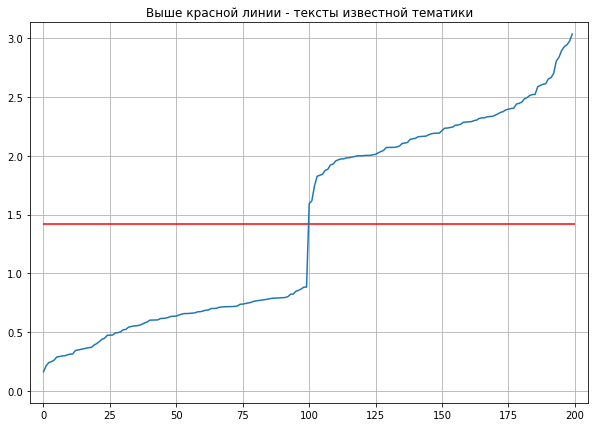

In [63]:
plt.figure(figsize = (10, 7) )
plt.plot(sorted(lst))
plt.ylim((-0.1, max(lst) + 0.1))
plt.xlim((-5, len(dfTst) + 5))
plt.hlines(avrg, 0, len(dfTst), color = 'r')
plt.title('Выше красной линии - тексты известной тематики')
plt.grid(True)


In [29]:
# инициализируем словарь списков номеров текстов
result = {
          'defined': [],
          'other'  : []
}


In [30]:
# заполним результирующие группы текстов 'defined' и 'other' 
j = 0
for i in lst:
    if i > avrg: 
        result['defined'].append(idTexts[j])
    else: 
        result['other'].append(idTexts[j])
    j += 1    

print(result)

{'defined': [514, 9, 2570, 3086, 1040, 1113, 3603, 2591, 2081, 2602, 1281, 1076, 569, 572, 2622, 78, 599, 89, 2139, 3600, 2144, 1121, 1123, 3433, 1139, 1658, 2173, 1664, 3719, 2185, 3214, 3224, 161, 3239, 1704, 683, 3256, 1211, 1215, 1728, 3268, 2758, 715, 2258, 219, 1244, 1757, 1262, 2799, 3824, 1779, 1270, 257, 3332, 775, 2313, 1294, 2324, 3349, 3368, 3293, 2864, 2353, 3892, 2869, 2362, 3904, 2885, 1355, 3405, 1360, 3415, 857, 347, 3940, 402, 2921, 1406, 2950, 1928, 3468, 1423, 3472, 2450, 2464, 2977, 2896, 427, 429, 958, 3524, 3013, 2504, 3020, 464, 2517, 3030, 336, 479, 2535], 'other': [3489, 3084, 2582, 1559, 1289, 2618, 1599, 2100, 579, 581, 586, 1720, 1616, 3665, 174, 85, 598, 1626, 2374, 2066, 3178, 1131, 2067, 624, 1659, 1151, 2696, 1932, 656, 1174, 665, 1691, 160, 3041, 1651, 1200, 2225, 2232, 695, 698, 3783, 1230, 1232, 1806, 808, 60, 1441, 1697, 1798, 273, 275, 3352, 1331, 1831, 307, 2579, 2876, 1343, 322, 836, 3398, 3913, 2386, 3925, 2902, 144, 2806, 999, 1909, 1911, 377, 

In [31]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [32]:
# запишем результат в JSON-файл
with open('/data/home/alexander.vertyagin/lab05.json', 'w') as write_file:
    json.dump(result, write_file, cls = NumpyArrayEncoder)